In [1]:
import os
import numpy as np

from collections import OrderedDict

from preprocess import *
from rgb_to_index import *
from download_and_extract import download_and_extract_archive

## Download and Extract Data

In [2]:
BIO3D_URL = "https://www.dropbox.com/s/lo6i7v2mc9z2wft/images-and-labels.zip?dl=1"
BIO3D_FILENAME = "platelet-em.zip"
BIO3D_MD5 = 'e3a7bb0b0099220781bfea3e5ee9430c'

download_and_extract_archive(
        BIO3D_URL, 
        '.', 
        filename=BIO3D_FILENAME,
        md5=BIO3D_MD5)

0it [00:00, ?it/s]

95756288it [00:03, 31022278.38it/s]                              


Extracting ./platelet-em/platelet-em.zip to ./platelet-em


## Load Data

In [3]:
# Choose some data/label pair 
main_data_dir = 'platelet-em'
raw_data_dir = os.path.join(main_data_dir, 'images')
raw_data_file = '50-images.tif'
label_data_dir = os.path.join(main_data_dir, 'labels-semantic')
label_data_file = '50-semantic.tif'

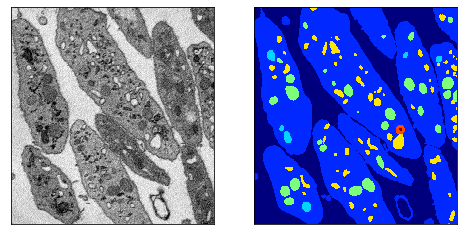

In [4]:
# Load raw and label data
raw_data = load(raw_data_dir, raw_data_file)

# Specify Data Type when loading label data
label_data = load(label_data_dir, label_data_file, data_type=np.int32)

# Label data is provided in RGB format (0-255). Convert to indices (0-7) as follows:
# First get the mapping from RGB to index
mappings = platelet_em_default_indexing()
label_data = rgb_to_index_semantic(label_data, mappings['rgb_to_index'])

# Show sample image (first image in each stack)
images = OrderedDict()
images[0] = raw_data[0]
images[1] = label_data[0]

plot_settings = OrderedDict()
plot_settings[0] = {'cmap': 'gray'}
plot_settings[1] = {'cmap':'jet', 'vmin':0, 'vmax':label_data.max()}

imshow(images, (8, 4), plot_settings)

## Data Augmentation: Elastic Deformation
We provide code for elastic deformation only. The user will likely want to add other common data augmentation and data normalization techniques. 

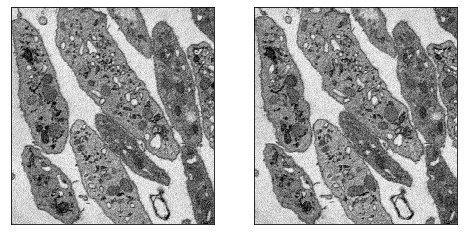

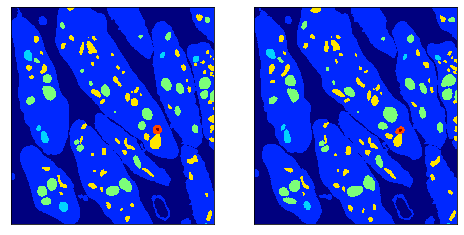

In [5]:
# Set deformation settings
deformation_settings = dict()
deformation_settings['scale'] = 40
deformation_settings['alpha'] = 20
deformation_settings['sigma'] = 0.6

# Choose deformation random seed (this is important to make sure both raw and label data are deformed the same).
deformation_random_seed = 1

# Perform elastic deformation
deformed_raw_data = deform(raw_data,
                           random_seed=deformation_random_seed)

deformed_label_data = deform(label_data,
                             random_seed=deformation_random_seed)

# Show effect of deformations
images = OrderedDict()
images[0] = raw_data[0]
images[1] = deformed_raw_data[0]

plot_settings = OrderedDict()
plot_settings[0] = {'cmap': 'gray'}
plot_settings[1] = {'cmap':'gray'}

imshow(images, (8, 4), plot_settings)

images = OrderedDict()
images[0] = label_data[0]
images[1] = deformed_label_data[0]

plot_settings = OrderedDict()
plot_settings[0] = {'cmap':'jet', 'vmin':0, 'vmax':label_data.max()}
plot_settings[1] = {'cmap':'jet', 'vmin':0, 'vmax':label_data.max()}

imshow(images, (8, 4), plot_settings)

## Windowing
We supply functionalities for random windowing as well as generating two windows of different shape centered at the same location (in case input and output of neural networks are different shapes). 

In [6]:
# Fix the windowing parameters
random_windowing = True
corner_generation_seed = 1
label_window_shape = [5, 100, 200] # corresponds to the shape output by the neural network (smaller than input)
window_spacing = [5, 50, 100] # implies there will be no overlap in z but half the image will overlap in x and y.
corner_generation_random_seed = None

# Generate a list of corner points for the labels
label_corner_points = gen_corner_points(spatial_shape=deformed_label_data.shape,
                                  window_spacing=window_spacing,
                                  window_shape=label_window_shape,
                                  random_windowing=random_windowing,
                                  random_seed=corner_generation_random_seed)

raw_window_shape = [5, 200, 400] # corresponds to the shape input to the neural network (larger than output)
# We choose a much larger raw_window_shape to illustrate what's going on

# Generate a list of corner poins for the raw inputs

raw_corner_points = gen_conjugate_corners(corner_points=label_corner_points,
                                          window_shape=label_window_shape,
                                          conjugate_window_shape=raw_window_shape)

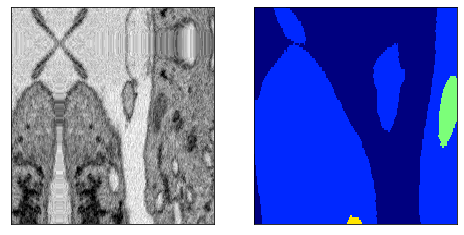

In [7]:
# Perform windowing
raw_window_generator = window_generator(deformed_raw_data,
                                        window_shape=raw_window_shape,
                                        corner_points=raw_corner_points)
label_window_generator = window_generator(deformed_label_data,
                                          window_shape=label_window_shape,
                                          corner_points=label_corner_points)

# Show sample windows (first image in each stack)
# Notice the mirroring on the left in the raw window!
images = OrderedDict()
images[0] = next(raw_window_generator)[0]
images[1] = next(label_window_generator)[0]

plot_settings = OrderedDict()
plot_settings[0] = {'cmap': 'gray'}
plot_settings[1] = {'cmap':'jet', 'vmin':0, 'vmax':label_data.max()}

imshow(images, (8, 4), plot_settings)

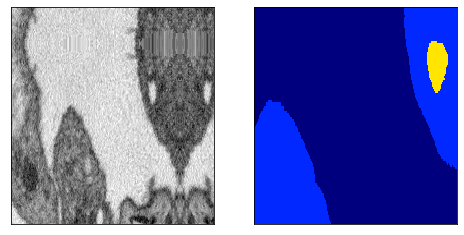

In [8]:
# We also plot another set of windows here
# Show sample windows (first image in each stack)
# Notice the mirroring on the left in the raw window!
images = OrderedDict()
for _ in range(5):
    images[0] = next(raw_window_generator)[0]
    images[1] = next(label_window_generator)[0]

plot_settings = OrderedDict()
plot_settings[0] = {'cmap': 'gray'}
plot_settings[1] = {'cmap':'jet', 'vmin':0, 'vmax':label_data.max()}

imshow(images, (8, 4), plot_settings)